In [1]:
# import libraries
from pyopenms import *
import os

In [2]:
# change directory to find file of interest
os.chdir(r'C:\Users\miar\Desktop\data')

In [3]:
#------------------------------------------------------------------------------------------------------------------------------

# ONLY NEED TO RUN THE NEXT THREE BLOCKS ONCE

#-------------------------------------------------------------------------------------------------------------------------------

In [4]:
# load the content of the mzML file into the exp variable of type MSExperiment
#exp = MSExperiment()
#MzMLFile().load("HEK293T_De_Novo_053122_Glu-C_B_correctRTSenzyme_BP.mzML", exp)

# access the raw data and spectra
#spectrum_data = exp.getSpectrum(0).get_peaks()
#spectrum_data

In [5]:
# loop through the spectra to gather MS2 scans
#specM2 = []
#for s in exp.getSpectra():
#    if s.getMSLevel() == 2:
#        specM2.append(s)
        
#print("Number of MS2 scans: " + str(len(specM2)))

#exp.setSpectra(specM2) # keep only MS2

# store the modified data structure on disk
#MzMLFile().store("filtered_MS2.mzML", exp)

In [6]:
# loop through the spectra to gather MS3 scans
#specM3 = []
#for s in exp.getSpectra():
#    if s.getMSLevel() == 3:
#        specM3.append(s)
        
#print("Number of MS3 scans: " + str(len(specM3)))

#exp.setSpectra(specM3) # keep only MS3

# store the modified data structure on disk
#MzMLFile().store("filtered_MS3.mzML", exp)

In [7]:
# parse functions
def parseScanLine(input):
    x = input.split(" For: ")
    [scan_number, mzs] = x[1].split(", ")
    [precursor_mz, fragment_mz] = mzs.split(";")
    trimmed_fragment_mz = fragment_mz.strip() # trim fragment strings to remove \n
    return [scan_number, precursor_mz, trimmed_fragment_mz]

def parseTargetIons(input):
    i = input.split('Target Fragment: ')
    ion = i[1].split(',')[0]
    return ion 

In [8]:
# checking lines of log file and creating dictionary of scan numbers and fragment mzs
try:
  
    # words to search for
    search = ' Submitted Custom Scan For:'
    search_target = 'Target Fragment:'
    
    # dict for scan numbers and corresponding fragments 
    scan2frag = dict()
    target_values = []
    with open('App-2022-05-31_20-49-35.log') as f:
        for line in f:
            if search in line:
                scan_number, precursor_mz, trimmed_fragment_mz = parseScanLine(line)
                scan2frag[scan_number] = [float(precursor_mz), float(trimmed_fragment_mz)]
            elif search_target in line:
                target_ion = parseTargetIons(line)
                target_values.append(target_ion) #to add to final dataframe
            
    # if the input string doesn't exist in the text file
    if len(scan2frag)==0:
        print("\n\"" +search+ "\" is not found in \"" +'App-2022-05-31_20-49-35.log'+ "\"!")

except FileNotFoundError:
    print("The file does not exist!")

In [9]:
# load in MS2 scans
exp1 = MSExperiment()
MzMLFile().load("filtered_MS2.mzML", exp1)

In [10]:
# read in peptide sequence from tsv
import pandas as pd
tsv = pd.read_csv('HEK293T_De_Novo_053122_Glu-C_B_correctRTSenzyme_BP_realtimesearch1.tsv', sep='\t')

# create dictionary with scan # as key and sequence/charge as values
scan2PeptideCharge = dict([(i, [x,y]) for i, x,y, in zip(tsv['Scan Number'], tsv['Peptide'], tsv['Charge State'])])

# removing all NaN sequences (not useful)
scan2PeptideCharge_modified = {k:v for k,v in scan2PeptideCharge.items() if str(v[0]) != 'nan'}

In [11]:
def findFragments(peptide_object, charge):
    # loop through each prefix and suffix (b and y ions, respectively)
    # y and b ions

    b_index = []
    y_index = []
    for ion in range(1, (peptide_object.size())): # start at index of 1, end at peptide length - 1
        y_ion = peptide_object.getSuffix(ion)
        b_ion = peptide_object.getPrefix(ion)

        for z in range(1, charge):
            mz_b = b_ion.getMonoWeight(Residue.ResidueType.BIon, z) / z
            b_index.append(s.findNearest(mz_b, 0.4))

            mz_y = y_ion.getMonoWeight(Residue.ResidueType.YIon, z) / z
            y_index.append(s.findNearest(mz_y, 0.4))

    y_index.reverse() # reverse list (the first b ion corresponds with the last y ion)
    
    # skim list for each corresponding y and b fragments based on charge states
    count = 0
    missing_list = []
    for fragment_index in range(0, len(y_index), charge-1): # check after 'x' mzs (possible charge states)
        
        count = count + 1
        
        check_b = b_index[fragment_index : fragment_index+charge-1]
        check_y = y_index[fragment_index : fragment_index+charge-1]

        if all(item == -1 for item in check_b) and all(item == -1 for item in check_y):
            missing_list.append(str(count))
        
        number_missing = len(missing_list)
        missing_list_mod = ",".join(str(i) for i in missing_list)

    return missing_list_mod, number_missing

In [12]:
table_rows = []
for s in exp1:
    s_number = s.getNativeID().split(' ')[-1]
    _, scan_number = s_number.split('=')
    
    if scan_number in scan2frag and int(scan_number) in scan2PeptideCharge_modified:
        # isolate peptide sequence from dict
        sequence = scan2PeptideCharge_modified[int(scan_number)][0]     
        trimmed_sequence = sequence[2:-2] # remove first two and last two characters 
        
        # isolate charge from dict
        charge = scan2PeptideCharge_modified[int(scan_number)][1]
 
        # create peptide object 
        peptide_object = AASequence.fromString(trimmed_sequence)
        
        # call findFragments function
        missing_list_mod, number_missing = findFragments(peptide_object, charge)
        
        # creating table
        #myTable.add_row([scan_number, trimmed_sequence, peptide_object.size(), missing_list])
        add_row = {'Scan_Number':scan_number, 
                'Sequence':trimmed_sequence,
                   'Charge':charge,
                'Sequence_Length':peptide_object.size(),
                'Missing_Fragment_Locations':missing_list_mod,
                   'Number_Missing':number_missing}
        table_rows.append(add_row)

In [13]:
# add columns in df for precursor and fragment mzs (used later for MS3 matching)
precursor_mzs = []
for scan in list(scan2frag):
    precursor_mzs.append(scan2frag[scan][0])
    
fragment_mzs = []
for scan in list(scan2frag):
    fragment_mzs.append(scan2frag[scan][1])

In [14]:
# create dataframe to be exported as table later 
df = pd.DataFrame(table_rows)
# add targeted fragment column and precursor mz column
fragment_df = df.assign(Target_Fragment=target_values)

In [15]:
fragment_df

,Scan_Number,Sequence,Charge,Sequence_Length,Missing_Fragment_Locations,Number_Missing,Target_Fragment
0,2140,IFKNGSKRMIATVPLRHSIRD,5,21,13,1,y6
1,2534,RQVPLASPSSM[15.9949]SAALRGISCYLKE,4,24,"1,4,5,6,8,10,13,14,16,21,22,23",12,y5
2,3148,KAQAIIATMGGTTLMASAHSWAKSSSFSCPE,4,31,"1,2,3,4,6,8,9,11,13,15,18,19,20,21,22,23,24,26...",22,b4
3,3582,KSSM[15.9949]KRKLPFTISPSRNE,4,18,"3,4,6,10,11,13,14,16",8,y3
4,3716,AVCGAGPPSGLLPLPGPDPGPRGSQGSPTPTRAPASGPE,5,39,"1,2,3,5,6,8,9,12,14,15,18,24,26,28,32,34,36,38",18,b4
...,...,...,...,...,...,...,...
2722,80065,IAPFLCHPNLWIRYGAVGFITVVARQISTAD,3,31,"5,8,12,13,14,16,21,23,27,28,29,30",12,y6
2723,80148,FKMHKKGYNRHNQCLTTSHSKIFQCD,4,26,19,1,b3
2724,80485,LTLLAFALARGSVAKVMSSLCTITD,4,25,"2,8,13,24",4,b6
2725,80530,IVNSLQKM[15.9949]QNKGGGD,2,15,"6,11",2,b2


In [16]:
# export df to tsv 
#fragment_df.to_csv('fragmentInfoTable.tsv', sep=' ', index=False)

In [17]:
# perform table modifications and plot histograms in R...
# ...
# ...

In [18]:
# read in modified table
checktargets_df = pd.read_csv('fragmentInfoTable_altered.tsv', sep="/t", engine='python')

In [75]:
# peek at the first 20 rows for manually checking if subsequent code has expected output
checktargets_df

,"""Scan_Number""","""Sequence""","""Sequence_Length""","""nTerminusEnd""","""Number_Missing""","""Target_Fragment""","""cTerminusEnd"""
0,2140,"""IFKNGSKRMIATVPLRHSIRD""",21,13.0,1,"""y6""",8.0
1,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,1.0,12,"""y5""",23.0
2,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,4.0,12,"""y5""",20.0
3,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,5.0,12,"""y5""",19.0
4,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,6.0,12,"""y5""",18.0
...,...,...,...,...,...,...,...
5553,80530,"""IVNSLQKM[15.9949]QNKGGGD""",15,6.0,2,"""b2""",9.0
5554,80530,"""IVNSLQKM[15.9949]QNKGGGD""",15,11.0,2,"""b2""",4.0
5555,82545,"""RPWNPPTFSPALLVVTE""",17,5.0,3,"""y4""",12.0
5556,82545,"""RPWNPPTFSPALLVVTE""",17,9.0,3,"""y4""",8.0


In [20]:
# load in MS3 scans
exp2 = MSExperiment()
MzMLFile().load("filtered_MS3.mzML", exp2)

In [21]:
# obtain MS3 scan numbers
# obtain precursor and fragment mzs directly from the MS3 spectrum

ms3scan2MZs = dict()
for s in exp2:
    s_number = s.getNativeID().split(' ')[-1]
    _, scan_number = s_number.split('=')
   
    fragment, precursor = s.getPrecursors()
    precursor_mz = precursor.getMZ()
    fragment_mz = fragment.getMZ()
    
    ms3scan2MZs[int(scan_number)] = [round(float(precursor_mz), 4), round(float(fragment_mz), 4)] # 4 decimal places, similar to log

In [58]:
def matchingMS3s(which_mz_list, type_str): # either fragment or precursor
    
    if type_str == 'Precursor mzs':
        values = []
        for i in list(ms3scan2MZs.values()):
            value = i[0]
            values.append(value)
    elif type_str == 'Fragment mzs':
        values = []
        for i in list(ms3scan2MZs.values()):
            value = i[1]
            values.append(value)
    
    # making sure they are within 100 scans of each other
    too_far = []
    for ms2scan, ms3scan in zip(list(scan2frag), list(ms3scan2MZs)):
        scan_diff = int(ms3scan) - int(ms2scan)
        if scan_diff > 100:
            too_far.append('Scans are not within 100 scans of each other...' + 'MS2 = ' + ms2scan + ' MS3 = ' + ms3scan)
    
    # do they not match off the bat?
    if values != which_mz_list:
        
        # taking into consideration rounding discrepencies between the log and the spectrum
        mismatch = []
        for i in range(0, len(which_mz_list)):
            diff = float(values[i]) - float(which_mz_list[i]) 
            if diff < 0.000101 or (diff < 0 and diff > -0.000101): # because sometimes max number will be 0.0001000002 for example
                pass
            else:
                mismatch.append(i)
                
        # no mismatch after rounding and within 100 scans
        if len(mismatch) == len(too_far) == 0:
            print(type_str + ' match up after taking rounding discrepencies into consideration')
            new_fragment_df = fragment_df.assign(MS3_Scan = list(ms3scan2MZs))
            return new_fragment_df
        elif len(mismatch) != 0:
            print('There is mismatch at the following indicies:') # if this is the case, need to do more work...
            for i in mismatch:
                print(i) 
        elif len(too_far) != 0:
            print(too_far)
       
    # they match perfectly
    elif values == which_mz_list:
        
        # within 100 scans
        if len(too_far) == 0:
            print(type_str + ' match up perfectly!')
            new_fragment_df = fragment_df.assign(MS3_Scan = list(ms3scan2MZs))
            return new_fragment_df
        else:
            print(too_far)

In [59]:
# matching precursor mzs between MS2 (log) and MS3 (spectrum)
new_fragment_df = matchingMS3s(precursor_mzs, 'Precursor mzs')

Precursor mzs match up after taking rounding discrepencies into consideration


In [60]:
# matching fragment mzs between MS2 (log) and MS3 (spectrum)
new_fragment_df = matchingMS3s(fragment_mzs, 'Fragment mzs')

Fragment mzs match up perfectly!


In [61]:
# after making sure MS2s and MS3s line up, we can continue...

In [62]:
# remove irrelevant information from df
new_fragment_df.drop(columns=['Number_Missing'], inplace=True)

new_fragment_df.rename(columns={'Scan_Number':'MS2_Scan'}, inplace=True)

In [63]:
new_fragment_df

,MS2_Scan,Sequence,Charge,Sequence_Length,Missing_Fragment_Locations,Target_Fragment,MS3_Scan
0,2140,IFKNGSKRMIATVPLRHSIRD,5,21,13,y6,2148
1,2534,RQVPLASPSSM[15.9949]SAALRGISCYLKE,4,24,"1,4,5,6,8,10,13,14,16,21,22,23",y5,2543
2,3148,KAQAIIATMGGTTLMASAHSWAKSSSFSCPE,4,31,"1,2,3,4,6,8,9,11,13,15,18,19,20,21,22,23,24,26...",b4,3158
3,3582,KSSM[15.9949]KRKLPFTISPSRNE,4,18,"3,4,6,10,11,13,14,16",y3,3585
4,3716,AVCGAGPPSGLLPLPGPDPGPRGSQGSPTPTRAPASGPE,5,39,"1,2,3,5,6,8,9,12,14,15,18,24,26,28,32,34,36,38",b4,3727
...,...,...,...,...,...,...,...
2722,80065,IAPFLCHPNLWIRYGAVGFITVVARQISTAD,3,31,"5,8,12,13,14,16,21,23,27,28,29,30",y6,80071
2723,80148,FKMHKKGYNRHNQCLTTSHSKIFQCD,4,26,19,b3,80156
2724,80485,LTLLAFALARGSVAKVMSSLCTITD,4,25,"2,8,13,24",b6,80493
2725,80530,IVNSLQKM[15.9949]QNKGGGD,2,15,"6,11",b2,80536


In [90]:
checktargets_df[:20]

,"""Scan_Number""","""Sequence""","""Sequence_Length""","""nTerminusEnd""","""Number_Missing""","""Target_Fragment""","""cTerminusEnd"""
0,2140,"""IFKNGSKRMIATVPLRHSIRD""",21,13.0,1,"""y6""",8.0
1,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,1.0,12,"""y5""",23.0
2,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,4.0,12,"""y5""",20.0
3,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,5.0,12,"""y5""",19.0
4,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,6.0,12,"""y5""",18.0
5,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,8.0,12,"""y5""",16.0
6,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,10.0,12,"""y5""",14.0
7,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,13.0,12,"""y5""",11.0
8,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,14.0,12,"""y5""",10.0
9,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,16.0,12,"""y5""",8.0


In [93]:
# fragments that were not found in MS2 but potentially could be found in MS3
ms3could_help = []
ms3no_help = []
table = []

scan = []
test = []
for i in checktargets_df.index:
    # target y ions
    
    if checktargets_df['"Target_Fragment"'][i].startswith('"y'):
        if str(checktargets_df.loc[i]['"cTerminusEnd"']) != 'nan' and int(checktargets_df['"Target_Fragment"'][i][-2]) >= int(checktargets_df['"cTerminusEnd"'][i]):
            
            ms3could_help.append(i)
            loc = checktargets_df['"nTerminusEnd"'][i]
            
            if checktargets_df['"Scan_Number"'][i] not in scan:
                scan.append(checktargets_df['"Scan_Number"'][i])
                
            row = {'MS2_Scan': checktargets_df['"Scan_Number"'][i], 'Location_from_nTerm': checktargets_df['"nTerminusEnd"'][i]}
            table.append(row)
        else:
            ms3no_help.append(i)
        
              
    # target b ions
    elif checktargets_df['"Target_Fragment"'][i].startswith('"b'):
        if str(checktargets_df.loc[i]['"nTerminusEnd"']) != 'nan' and int(checktargets_df['"Target_Fragment"'][i][-2]) >= int(checktargets_df['"nTerminusEnd"'][i]):
            
            ms3could_help.append(i)
            loc = checktargets_df['"nTerminusEnd"'][i]
            
            if checktargets_df['"Scan_Number"'][i] not in scan:
                scan.append(checktargets_df['"Scan_Number"'][i])
                
            row = {'MS2_Scan': checktargets_df['"Scan_Number"'][i], 'Location_from_nTerm': checktargets_df['"nTerminusEnd"'][i]}
            table.append(row)
        else: 
            ms3no_help.append(i)
            
        
    locs.append(loc)

In [92]:
locs

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [21.0],
 [22.0],
 [23.0],
 [1.0],
 [2.0],
 [3.0],
 [4.0],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [16.0],
 [1.0],
 [2.0],
 [3.0],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [16.0],
 [17.0],
 [],
 [],
 [],
 [3.0],
 [5.0],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [15.0],
 [16.0],
 [1.0],
 [2.0],
 [3.0],
 [4.0],
 [],
 [],
 [],
 [],
 [],
 [1.0],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [8.0],
 [9.0],
 [10.0],
 [],
 [],
 [7.0],
 [8.0],
 [9.0],
 [10.0],
 [11.0],
 [1.0],
 [],
 [],
 [],
 [],
 [1.0],
 [2.0],
 [3.0],
 [],
 [],
 [],
 [],
 [],
 [4.0],
 [5.0],
 [],
 [],
 [],
 [],
 [11.0],
 [1.0],
 [],
 [1.0],
 [2.0],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [11.0],
 [],
 [],
 [],
 [],
 [],

In [83]:
scan

[2534,
 3148,
 3582,
 3716,
 4111,
 4150,
 4239,
 4246,
 4281,
 4289,
 4292,
 4297,
 4299,
 4305,
 4323,
 4326,
 4349,
 4354,
 4366,
 4403,
 4405,
 4444,
 4503,
 4506,
 4599,
 4605,
 4615,
 4649,
 4659,
 4666,
 4673,
 4689,
 4719,
 4774,
 4776,
 4801,
 4803,
 4818,
 4819,
 4825,
 4836,
 4842,
 4862,
 4873,
 4880,
 4882,
 4896,
 4908,
 4912,
 4919,
 4958,
 4997,
 5006,
 5007,
 5030,
 5037,
 5046,
 5057,
 5064,
 5079,
 5081,
 5110,
 5127,
 5128,
 5141,
 5157,
 5185,
 5186,
 5196,
 5223,
 5241,
 5247,
 5274,
 5276,
 5329,
 5330,
 5353,
 5361,
 5381,
 5389,
 5391,
 5401,
 5405,
 5442,
 5454,
 5456,
 5470,
 5484,
 5486,
 5503,
 5521,
 5549,
 5565,
 5570,
 5593,
 5619,
 5643,
 5654,
 5662,
 5704,
 5715,
 5734,
 5758,
 5788,
 5813,
 5829,
 5848,
 5858,
 5874,
 5940,
 5966,
 6003,
 6027,
 6062,
 6067,
 6107,
 6108,
 6182,
 6200,
 6212,
 6274,
 6342,
 6408,
 6441,
 6463,
 6556,
 6560,
 6588,
 6617,
 6746,
 6756,
 6799,
 6815,
 6824,
 6832,
 6875,
 6920,
 6924,
 6991,
 7034,
 7102,
 7111,
 7174,

In [46]:
pd.DataFrame(table)

,MS2_Scan,Location_from_nTerm
0,2534,21.0
1,2534,22.0
2,2534,23.0
3,3148,1.0
4,3148,2.0
...,...,...
1131,80065,27.0
1132,80065,28.0
1133,80065,29.0
1134,80065,30.0


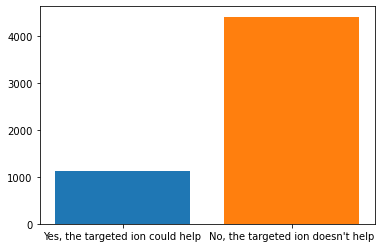

In [94]:
import matplotlib.pyplot as plt
plt.bar('Yes, the targeted ion could help', len(ms3could_help))
plt.bar('No, the targeted ion doesn\'t help', len(ms3no_help))
plt.show()

In [64]:
def findFragmentsMS3(peptide_object, charge, i):
    
    y_index = []
    b_index = []

    # targeted fragment is a y ion
    if new_fragment_df['Target_Fragment'][i].startswith('y'):
        y_num = new_fragment_df['Target_Fragment'][i][-1]

        # the full sequence of the fragment
        full_seq = peptide_object.getSuffix(int(y_num))

        # checking fragment for its y ions
        for ion in range(1, int(y_num)):
            y_ion = full_seq.getSuffix(ion)
            for z in range(1, charge):
                mz_y = y_ion.getMonoWeight(Residue.ResidueType.YIon, z) / z
                y_index.append(exp2[i].findNearest(mz_y, 0.4))

        # reverse list (the first b ion corresponds with the last y ion)
        y_index.reverse() 

        # checking fragment for b ions
        for ion in range(1, int(y_num)):
            b_ion = full_seq.getPrefix(ion)
            for z in range(1, charge):
                mz_b = b_ion.getMonoWeight(Residue.ResidueType.Internal, z) / z
                b_index.append(exp2[i].findNearest(mz_b, 0.4))
                
    # targeted fragment is a b ion
    elif new_fragment_df['Target_Fragment'][i].startswith('b'):
        b_num = new_fragment_df['Target_Fragment'][i][-1]

        # the full sequence of the fragment
        full_seq = peptide_object.getPrefix(int(b_num))

        # checking fragment for its b ions
        for ion in range(1, int(b_num)):
            b_ion = full_seq.getPrefix(ion)
            for z in range(1, charge):
                mz_b = b_ion.getMonoWeight(Residue.ResidueType.BIon, z) / z
                b_index.append(exp2[i].findNearest(mz_b, 0.4))

        # checking fragment for y ions
        for ion in range(1, int(b_num)):
            y_ion = full_seq.getPrefix(ion)
            for z in range(1, charge):
                mz_y = y_ion.getMonoWeight(Residue.ResidueType.Internal, z) / z
                y_index.append(exp2[i].findNearest(mz_y, 0.4))

        # reverse list (the first b ion corresponds with the last y ion)
        y_index.reverse()

    count = 0
    foundinMS3 = []
    for fragment_index in range(0, len(y_index), charge-1): # check after 'x' mzs (possible charge states)

        count = count + 1

        check_y = y_index[fragment_index : fragment_index+charge-1]
        check_b = b_index[fragment_index : fragment_index+charge-1]

        if all(item == -1 for item in check_b) and all(item == -1 for item in check_y): # missing fragments
            pass 
        else:
            foundinMS3.append(count) # locations on the fragment that are NOT missing
        
    if len(foundinMS3) == 0:
        foundinMS3.append('nan')
       
    test = ",".join(str(i) for i in foundinMS3)

    return foundinMS3, str(full_seq)

In [65]:
found_list = [] 
fragment_seqs = []
for i in new_fragment_df.index:
    
    # create peptide object for the sequence
    peptide_object = AASequence.fromString(new_fragment_df['Sequence'][i])
    
    # the charge associated with this sequence
    charge = new_fragment_df['Charge'][i]
    
    # call findFragmentsMS3 function 
    foundinMS3, full_seq = findFragmentsMS3(peptide_object, charge, i)
    
    found_list.append(foundinMS3)
    fragment_seqs.append(full_seq)

In [66]:
# changing str 'nan' to float nan for easy removal in dataframe
found_list_modified = []

for i in found_list:
    if i == 'nan':
        i = float('nan')
        found_list_modified.append(i)
    else:
        found_list_modified.append(i)

In [67]:
# modifying dataframe to make life easier (hopefully)

# change full sequences to fragment sequences 
new_fragment_df = new_fragment_df.assign(Fragment_Sequence = fragment_seqs)

# add column of locations found in fragment 
new_fragment_df = new_fragment_df.assign(Locations_Found=found_list_modified)

# remove any rows with NaN locations found 
for i in new_fragment_df.index:
    if new_fragment_df['Locations_Found'][i] == ['nan']:
        new_fragment_df.drop(i, axis=0, inplace=True)

# drop charge (no longer needed)
new_fragment_df.drop(columns=['Charge'], inplace=True)

# make MS3 scan numbers the new index
#new_fragment_df.set_index('MS3_Scan_Number', inplace=True)

In [68]:
new_fragment_df

,MS2_Scan,Sequence,Sequence_Length,Missing_Fragment_Locations,Target_Fragment,MS3_Scan,Fragment_Sequence,Locations_Found
1,2534,RQVPLASPSSM[15.9949]SAALRGISCYLKE,24,"1,4,5,6,8,10,13,14,16,21,22,23",y5,2543,CYLKE,"[3, 4]"
3,3582,KSSM[15.9949]KRKLPFTISPSRNE,18,"3,4,6,10,11,13,14,16",y3,3585,RNE,[1]
9,4150,KPATDPVLQVVYKSQGKE,18,"3,5,7,12,15",b6,4153,KPATDP,"[1, 5]"
12,4239,AYYRRVKRLYSNWRKGE,17,"1,4,5,6,8,9,15,16",y3,4242,KGE,[2]
13,4246,CSRAGGNCCKKCTLTHD,17,"1,2,3,4,8,9,11,14",b6,4248,CSRAGG,"[2, 4]"
...,...,...,...,...,...,...,...,...
2699,79115,AIGVIFTHVRLLARAFTLRTVGFNHLTLGHNQRME,35,,y5,79124,NQRME,"[1, 3, 4]"
2702,79440,QVTVNKARAPAFSMGIRHSKRASTM[15.9949]AATTPSRPAGHR...,43,"2,14,19,31",y4,79443,GRCC,"[2, 3]"
2704,79459,MLIPMASVMAVTEPKWVSVWSRFLWVTLLSM[15.9949]VLGSLL...,47,"3,23",y5,79465,LGAVE,[2]
2712,79736,LQRSLPPVMAQNLSIPLAFACLLHLANE,28,"14,19,20,27",b5,79746,LQRSL,"[1, 4]"


In [69]:
locations = []
for i in new_fragment_df.index:
    if new_fragment_df['Target_Fragment'][i].startswith('y'):
        frag_length = len(new_fragment_df['Fragment_Sequence'][i])
        whole_seq_length = new_fragment_df['Sequence_Length'][i]
        starting_loc = whole_seq_length - frag_length # starting point - location from n terminus 
        
    elif new_fragment_df['Target_Fragment'][i].startswith('b'):
        starting_loc = 0 # starts at beginning of sequence

    test = []
    for x in new_fragment_df['Locations_Found'][i]:
        location = starting_loc + x
        
        test.append(location)
        
    locations.append(test) #distance away from n terminus 

In [70]:
# overwrite locations column to resemble location from n terminus 
new_fragment_df['Locations_Found'] = locations

In [71]:
checkMS3 = new_fragment_df.drop(columns=['Sequence', 'Sequence_Length', 'Target_Fragment', 'Fragment_Sequence'])

In [76]:
checkMS3

,MS2_Scan,Missing_Fragment_Locations,MS3_Scan,Locations_Found
1,2534,"1,4,5,6,8,10,13,14,16,21,22,23",2543,"[22, 23]"
3,3582,"3,4,6,10,11,13,14,16",3585,[16]
9,4150,"3,5,7,12,15",4153,"[1, 5]"
12,4239,"1,4,5,6,8,9,15,16",4242,[16]
13,4246,"1,2,3,4,8,9,11,14",4248,"[2, 4]"
...,...,...,...,...
2699,79115,,79124,"[31, 33, 34]"
2702,79440,"2,14,19,31",79443,"[41, 42]"
2704,79459,"3,23",79465,[44]
2712,79736,"14,19,20,27",79746,"[1, 4]"
